In [1]:
# Propagate previous outputs to the current version
! cp -r  "/kaggle/input/simone-bertolotto-857533/estimators" "/kaggle/working/"
! cp -r  "/kaggle/input/simone-bertolotto-857533/learning_curves" "/kaggle/working/"
! cp -r  "/kaggle/input/simone-bertolotto-857533/solutions" "/kaggle/working/"
! cp -r  "/kaggle/input/simone-bertolotto-857533/features" "/kaggle/working/"

cp: directory /kaggle/working does not exist
cp: directory /kaggle/working does not exist
cp: directory /kaggle/working does not exist
cp: directory /kaggle/working does not exist


In [2]:
# Workspace paths
from pathlib import Path

# Path to dirs
input_path = Path("../input")
working_path = Path(".")
temp_path = Path("../temp")

# Create some subdirs if don't exist
(working_path / "estimators").mkdir(exist_ok=True)
(working_path / "solutions").mkdir(exist_ok=True)
(working_path / "learning_curves").mkdir(exist_ok=True)
(working_path / "features").mkdir(exist_ok=True)

# Import & utility functions

In [3]:
# en_core_web_lg already installed in Kaggle kernels
# ! python -m spacy download en_core_web_lg

In [4]:
from datetime import datetime
import re
import string
import time
import logging
import multiprocessing

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from tqdm import tqdm

from IPython.core.display import display, HTML

from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import (
    roc_auc_score,
    check_scoring,
    get_scorer,
    # plot_roc_curve,
    roc_curve,
    auc,
    RocCurveDisplay,
)
from sklearn.model_selection import (
    GridSearchCV,
    ParameterGrid,
    learning_curve,
    train_test_split,
    cross_val_score,
)
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    Normalizer,
    Binarizer,
    MaxAbsScaler,
    StandardScaler,
    RobustScaler,
    QuantileTransformer,
    PowerTransformer,
)
from sklearn.svm import LinearSVC, SVC
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.exceptions import NotFittedError
from sklearn.utils import estimator_html_repr

import tensorflow as tf
import keras_tuner as kt  # complains about TPU

import en_core_web_lg

from gensim.models.doc2vec import Doc2Vec, TaggedDocument, FAST_VERSION
from gensim.models.callbacks import CallbackAny2Vec

/Users/simo/Developer/reddit/venv/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [5]:
# caches location for sklearn preprocessing
caches = joblib.Memory(temp_path)

# number of available CPU cores
CPU = multiprocessing.cpu_count()

# GridSearchCV will be used a lot for validation, so here are the standard parmas used:
GS = dict(
    n_jobs=-1,  # parallel execution on all the available cores
    verbose=1,  # help for backtracing
    return_train_score=True,  # train_score are used for plotting validation curves
    scoring="roc_auc",  # it's a good metric for binary classification of unbalanced dateset
    cv=10,  # more fold reduce variance estimation of validation score
)

# basing logging level for gensim output
# logging.basicConfig(level=logging.INFO)

# check for C libs for gensim
assert FAST_VERSION > -1

# convert python variable into a string, useful for estimators naming
def var2str(var):
    for key, value in globals().items():
        if id(value) == id(var):
            return key


# display sklearn estimator as HTML diagram
def diagram(estimator):
    # print(estimator_html_repr(estimator))
    return display(HTML(f"<div align=center>{estimator_html_repr(estimator)} </div>"))

Training (fit, in sklearn jargon) is a time consuming process, so the trained model shouldn't be lost.
The following custom `fit()` function always save the model. Moreover if there exist an already trained version in the
`./estimators` load it insted of train new model. This function is prefer over the scikit-learn standard 
`estimator.fit(X, y=None)` beacuse in `fit()` custom behaviors can be implemented such as:

- timing the fit process
- dinamically load pre-trained estimators
- automatic estimator saving
- automatic estimator naming
- automatic estimator versioning

In [6]:
def fit(estimator, X, y=None, load=True, save=True):

    # can't be ISO 8601 because has to be a valide filename
    now = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    name = var2str(estimator)

    # search for pre-trained estimators
    estimators = sorted((working_path / "estimators").glob(f"{name}_2021*.joblib"))
    print(f"FOUND\t{len(estimators)} {name} estimators")

    if load and estimators:
        estimator = joblib.load(estimators[-1])
        version = estimators[-1].stem.split("_")[-1]
        estimator.version = version
        estimator.name = name
        # TODO check that hyperparms are the same
        print(f"LOAD\t{estimators[-1]}")

    else:
        start_time = time.time()
        estimator.fit(X, y=y)
        estimator.version = now
        estimator.name = name
        elapsed_time = time.gmtime(time.time() - start_time)
        print(f"FIT\t{name} tooks {time.strftime('%X', elapsed_time)}")

        if save:
            path = working_path / "estimators" / f"{name}_{now}.joblib"
            joblib.dump(estimator, path)
            print(f"SAVE\t{name} to {path}")

    print()
    return estimator

Plots can give many insights about machine learning procedures. Here are some
plot function that will be used throughout the notebook:

- `plot_validation_curves`: how validation score changes with respect a single hyperparm
- `plot_validation_heatmaps`: how validation score changes with respect two hyperparms
- `plot_learning_curves`: how validation score changes with different number of training samples
- `plot_svd`: plot high dimensional vector in a 2D plane using SVD (Singular Value Decomposition)
- `plot_roc_curve`: plot ROC (Receiver Operating Characteristic) curve and add AUC (Area Under Curve) score to legend

In [7]:
def plot_mean_std(x, mean, std, logx=True, color="tab:orange", **kwargs):
    plot = plt.semilogx if logx else plt.plot
    plot(x, mean, color=color, **kwargs)
    plt.fill_between(x, mean - std, mean + std, color=color, alpha=0.2)


def plot_heatmap(x, y, score):
    plt.imshow(score, cmap=plt.cm.hot)
    max_y, max_x = np.unravel_index(score.argmax(), score.shape)
    plt.plot(max_x, max_y, "*", color="black")
    plt.colorbar()
    plt.xticks(np.arange(len(y)), y, rotation=45)
    plt.yticks(np.arange(len(x)), x)


def plot_validation_curves(estimator, param, **kwargs):
    cv = pd.DataFrame(estimator.cv_results_)
    score = estimator.best_score_
    x = cv[param].astype(np.float64)
    plt.figure(figsize=(14, 7))
    plt.title(f"Validation curves - {estimator.name}")
    plt.xlabel(param)
    plt.ylabel("Score")
    plot_mean_std(
        x,
        cv["mean_train_score"],
        cv["std_train_score"],
        label="TRAIN",
        linestyle="--",
        **kwargs,
    )
    plot_mean_std(
        x, cv["mean_test_score"], cv["std_test_score"], label="TEST", **kwargs
    )
    plt.axhline(score, color="grey", linestyle="dotted", label=f"{score:.5f}")
    plt.legend(loc="best")
    plt.show()


def plot_validation_heatmaps(estimator, param1, param2):
    cv = pd.DataFrame(estimator.cv_results_)
    x = [
        f"{j:.2}" if i % 2 == 0 else ""
        for i, j in enumerate(cv[param1].unique().astype(float))
    ]
    y = [
        f"{j:.2}" if i % 2 == 0 else ""
        for i, j in enumerate(cv[param2].unique().astype(float))
    ]
    train_score = cv.mean_train_score.values.reshape(len(x), len(y))
    test_score = cv.mean_test_score.values.reshape(len(y), len(x))

    plt.figure(figsize=(16, 5))
    plt.suptitle(f"Validation heatmaps - {estimator.name}")

    plt.subplot(1, 2, 1)
    plt.title(f"TRAIN - ★ {train_score.max():.5f}")
    plot_heatmap(x, y, train_score)
    plt.xlabel(param2)
    plt.ylabel(param1)

    plt.subplot(1, 2, 2)
    plt.title(f"TEST - ★ {test_score.max():.5f}")
    plot_heatmap(x, y, test_score)
    plt.xlabel(param2)
    plt.ylabel(param1)

    plt.show()


def plot_learning_curves(estimator, X, y, extrapolate=0, **kwargs):
    npy = working_path / "learning_curves" / f"{estimator.name}_{estimator.version}.npy"
    name = estimator.name

    if hasattr(estimator, "best_estimator_"):
        estimator = estimator.best_estimator_

    if npy.is_file():
        samples, train_mean, train_std, test_mean, test_std = np.load(npy)

    else:
        samples, train_scores, test_scores = learning_curve(
            estimator,
            X,
            y,
            scoring="roc_auc",
            train_sizes=np.linspace(0.1, 1.0, 10),
            n_jobs=-1,
            verbose=10,
            **kwargs,
        )
        train_mean, train_std = train_scores.mean(axis=1), train_scores.std(axis=1)
        test_mean, test_std = test_scores.mean(axis=1), test_scores.std(axis=1)
        np.save(npy, np.stack((samples, train_mean, train_std, test_mean, test_std)))

    plt.figure(figsize=(14, 7))
    plt.title(f"Learning curves - {name}")
    plt.xlabel("Samples")
    plt.ylabel("Score")
    plot_mean_std(
        samples,
        train_mean,
        train_std,
        logx=False,
        label="TRAIN",
        color="tab:blue",
        linestyle="--",
    )
    plot_mean_std(
        samples, test_mean, test_std, logx=False, label="TEST", color="tab:blue"
    )

    if extrapolate > samples[-1]:
        fit_samples = np.linspace(samples[0], extrapolate * 1.05, 20)

        def func(x, a, b, c):
            # Mazur, J.E., Hastie, R., 1978. Learning as accumulation: a reexamination
            # of the learning curve. Psychological Bulletin 85 (6), 1256e1274.
            return a * ((x + b) / (x + b + c))

        bounds = ([-np.inf, 1e-10, 1e-10], [np.inf, np.inf, np.inf])
        fit_params, _ = curve_fit(func, samples, test_mean, bounds=bounds)
        fit_scores = func(fit_samples, *fit_params)
        fit_score = func(extrapolate, *fit_params)
        plt.plot(fit_samples, fit_scores, linestyle="dotted", alpha=0.5)
        plt.plot(extrapolate, fit_score, "*", label=f"{fit_score:.5f}", color="orange")

    plt.legend(loc="best")
    plt.show()


def plot_svd(X, y, title="SVD"):
    X_svd = TruncatedSVD(2).fit_transform(X)
    color = ["tab:pink" if author else "tab:blue" for author in y]
    plt.scatter(X_svd[:, 0], X_svd[:, 1], marker=".", color=color, alpha=0.8)
    plt.title(title)


def plot_roc_curve(y_test, y_pred, ax, name=""):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    label = f"{name} (AUC = {roc_auc:0.5f})"
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax, name=label)

A simple function that takes an estimator and X_TEST data to produce a CSV file containing predictions (the one submitted to Kaggle).

In [8]:
def solution(estimator, data):
    """
    estimator: sklearn estimator used for prediction with `predict_proba` method
    data: test data in the format expected by the estimator
    """
    path = working_path / "solutions" / f"{estimator.name}_{estimator.version}.csv"
    if path.is_file():
        print(f"SOL. EXISTS AT \t{path}")
        return
    prediction = estimator.predict_proba(data)[:, 1]
    pd.DataFrame({"author": TEST_AUTHORS, "gender": prediction}).to_csv(
        path, index=False
    )
    print(f"SOL.\t{path}")

# Features extraction

In [9]:
# explicit type conversion ensure that all columns have the expected type

test_data = pd.read_csv(input_path / "datamining2021" / "test_data.csv").astype(
    {"author": str, "subreddit": str, "created_utc": int, "body": str}
)
train_data = pd.read_csv(input_path / "datamining2021" / "train_data.csv").astype(
    {"author": str, "subreddit": str, "created_utc": int, "body": str}
)
train_target = pd.read_csv(
    input_path / "datamining2021" / "train_target.csv", index_col="author", squeeze=True
)

In [10]:
Y = np.array([train_target[author] for author, _ in train_data.groupby("author")])
TEST_AUTHORS = sorted(test_data.author.unique())

Two are the important features avaiable in data that can help with the gender prediction: *subreddits* and *text* (text content of a commemnt). I grouped comments by user so I know what he/she wrote and on which subreddits; this give a more insights about user interested and beheavoiur.

In the following I'd like to eveluate the performance of the models before sending the result to kaggle and obtain the final score of the model. To do so a part of the TRAIN data is kept aside and used as test dataset. Here are the naming convention for datasets and models used throughtout the notebook:

- `S` and `T` in variables names refer to *subreddit* and *text* respectevily.
- *uppercase* data variables are objects that deal with all data available
- *lowercase* data variables are objects that deal with a part of data (e.g. train/test split)
- `X` in data variables means that it is a vectorized data, i.e. a matrix of numbers

Vectorized version of the whole `TRAIN` datasets will be used to train the final versions of models. `TEST` datasets are given to final version of model and obtain the predictions that will be sent to Kaggle.

`X_train` and `X_test` will be used to train and test models inside the notebook. If the obtained test score is sufficiently high, the model will be consider sucessful and will be trained on the whole dataset (`X_TRAIN`) and prediction of `X_TEST` will be sent to Kaggle.

The reason to used two different vectorizer (`VECTORIZER` and `vectorizer`) is to avoide "`test` dataset contamination". Infact if the vectorizer is fit on the whole data could contains some information about `test` data, an undesiderable circunstance.

Some observations of arguments of `train_test_split`:
- `random_state` has to be the same beteewn S-split and T-split otherwise these two features cannot be combined in a model (different author are selected for train and test).
- `stratify` is important when dealing with unbalanced dataset, it ensure the same unbalanced in the train and in the test datasets.

# Feature - Subreddits


In [11]:
def subreddits(data):
    return [group.subreddit.str.cat(sep=" ") for _, group in data.groupby("author")]


S_TRAIN = subreddits(train_data)
S_TEST = subreddits(test_data)

# Vectorization of ALL TEST and TRAIN data.
S_VECTORIZER = CountVectorizer(dtype="int", lowercase=False)
S_X_TRAIN = S_VECTORIZER.fit_transform(S_TRAIN)
S_X_TEST = S_VECTORIZER.transform(S_TEST)

# Split TRAIN in train and test. test will be used to evaluate the performance.
S_train, S_test, y_train, y_test = train_test_split(
    S_TRAIN, Y, test_size=0.20, random_state=42, stratify=Y
)

# Vectorization of test and train data.
S_vectorizer = CountVectorizer(dtype="int", lowercase=False)
S_X_train = S_vectorizer.fit_transform(S_train)
S_X_test = S_vectorizer.transform(S_test)


*Subreddits* feature can give some insights about users interests; if a user leave a comment on a particular subreddit, he/she is probably interested about that topic. Before feeding a model with data, some preprocessing is required. There are users that wrote hundreds of comments while others just wrote a couple. The purpose of preprocessing is to rescale these differents quantities so the models can yield better predictions.

Six differents types of preprocessing are performed, then the result are passed to a `TruncatedSVD` estimator that squashes high-dimentional features space (number of different subreddits) into a 2d plane. The plots shows that different preprocessing tecniques produce different results. The goal is to separate the blue dots from the pink ones in other to make the life easier for the classifier.

FOUND	1 S_quantile_uniform estimators
LOAD	estimators/S_quantile_uniform_2021-08-23T13-13-20.joblib

FOUND	1 S_quantile_normal estimators
LOAD	estimators/S_quantile_normal_2021-08-23T13-13-52.joblib



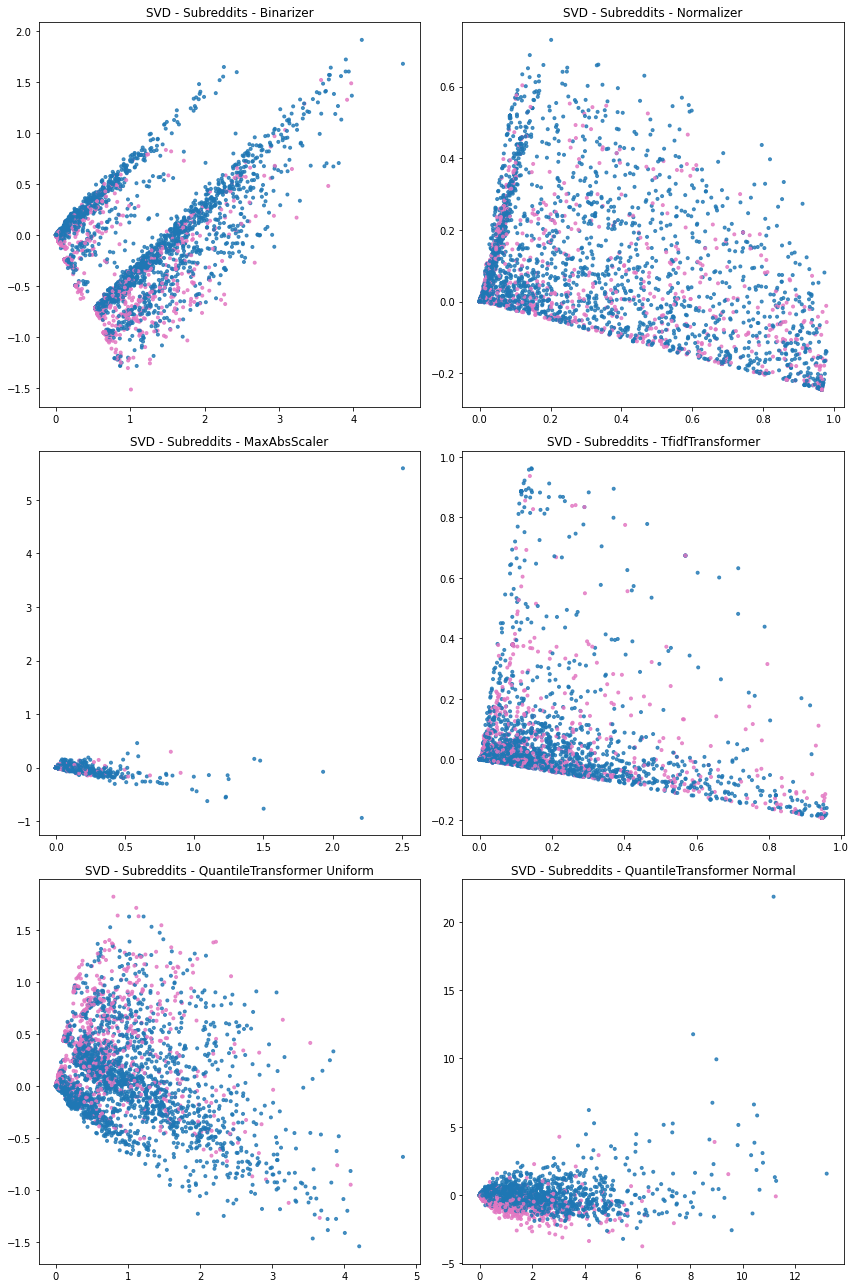

In [12]:
S_quantile_uniform = QuantileTransformer(output_distribution="uniform")
S_quantile_uniform = fit(S_quantile_uniform, S_X_train)
S_quantile_normal = QuantileTransformer(output_distribution="normal")
S_quantile_normal = fit(S_quantile_normal, S_X_train)

names = [
    "Binarizer",
    "Normalizer",
    "MaxAbsScaler",
    "TfidfTransformer",
    "QuantileTransformer Uniform",
    "QuantileTransformer Normal",
]

preprocessors = [
    Binarizer().fit_transform(S_X_train),
    Normalizer().fit_transform(S_X_train),
    MaxAbsScaler().fit_transform(S_X_train),
    TfidfTransformer().fit_transform(S_X_train),
    S_quantile_uniform.transform(S_X_train),
    S_quantile_normal.transform(S_X_train),
]

plt.figure(figsize=(12, 18))
for i, (name, preprocessor) in enumerate(zip(names, preprocessors)):
    plt.subplot(3, 2, i + 1)
    plot_svd(preprocessor, y_train, title=f"SVD - Subreddits - {name}")

plt.tight_layout()
plt.show()

In this notebook I will experimenting with two types of preprocessing:
- `Binarizer`: 1 if user leave a comment on that suberddit otherwise 0. It's simple and computationally fast.
- `QuantileTransformer Normal`: it's a non-linear transformation. It's quite computationally expensive.

## Models

Different models are tried for classification based on subreddits. They are defined using the concept of `Pipeline` that allow to concatenate subsequantial transformations and the classification is done in the last step of the pipeline. The pipeline is nested in a `GridSearchCV` for hyperparms optimization.

Here is the convention for models naming:
- `S_` or `T_`: on which feature the model is trained on: subreddits or text.
- `_preprocessing_`: various preprocessing steps
- `_classifier`: the classification model at the end of the pipeline.
- `_final`: if the model is trained on the whole dataset and used for kaggle evaluation



*example:*
`S_binarizer_svm_linear` is a model trained on `S_X_train` (not the whole training dataset) that perform "binarization“ followed by a Linear SVD classfication.


### Linear SVM

Linear SVM are succesful models for classification that rely on solid mathematical foundation. Here this model is tested with *binarizer* and *quantile* preprocessing. The hyperparam is only one `C` (proportional to the inverse of regularization) and the best value is determined by cross-validation (to be precise sklearn implements `StratifiedKFold` so each fold is unbalanced as the origianl dataset).

FOUND	1 S_binarizer_svm_linear estimators
LOAD	estimators/S_binarizer_svm_linear_2021-08-23T13-14-29.joblib



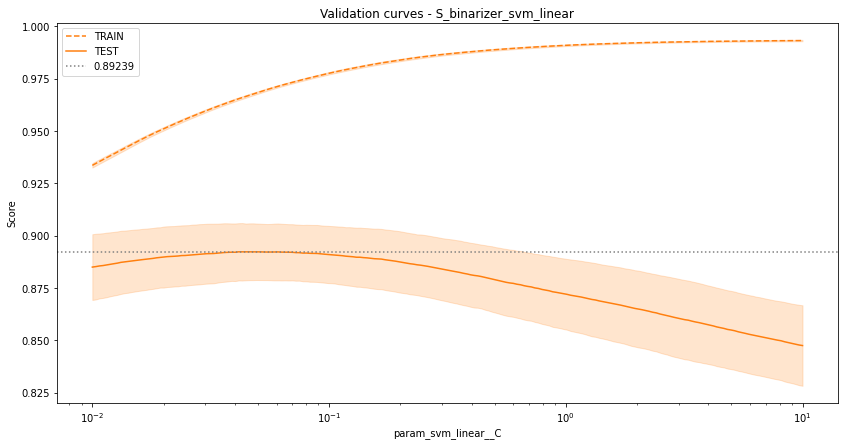

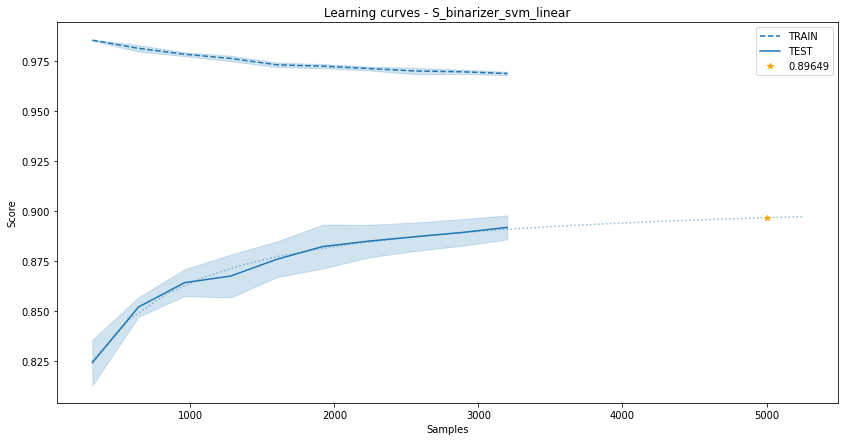

In [13]:
S_binarizer_svm_linear = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            (
                "svm_linear",
                LinearSVC(
                    class_weight="balanced",  # account for class imbalance
                    random_state=42,  # repeatability of results
                    max_iter=5000,  # increased for solution convergence
                ),
            ),
        ],
        memory=caches,
    ),
    {"svm_linear__C": np.logspace(-2, 1, 200),},  # logspace for hyperparam interval
    **GS
)

S_binarizer_svm_linear = fit(S_binarizer_svm_linear, S_X_train, y_train)

diagram(S_binarizer_svm_linear)
plot_validation_curves(S_binarizer_svm_linear, "param_svm_linear__C")
plot_learning_curves(S_binarizer_svm_linear, S_X_train, y_train, len(train_target))

`GridSearchCV` gives us data about hyperparsms optimization for free that can be used to construct different plots. When there is just one hyperparam `plot_validation_curves` shows how TRAIN and TEST scores change for different value of the hyperparam. The higher validation score is highlighted by a gray dotted line. This type of plot are called `Validation plot`


Learning curves show how much the performance can improve if the model is fitted with different number of training samples. The whole training dataset contains 5000 samples, 4000 are in S_X_train and 1000 in S_X_test. Sample in S_X_train are used for draw learning curves and TEST score is calculated with 5-fold cross-validation. I used `scipy.optimize.curve_fit` to fit TRAIN score and try to predict the score for the model trained on the whole dataset (5000 sample, orange star ★).


`LinearSVC` is implemented with *liblinear* (a library for large linear classification) which scales better than *libsvm* (the library used in `SVC`). The drawback is that *liblinear* does not have a built in probability estimation but a similar result can be obtain using `CalibratedClassifierCV`. After the fit, `S_calibrated_binarizer_svm_linear` is now equipped with `predict_proba` method.

In [14]:
S_calibrated_binarizer_svm_linear = CalibratedClassifierCV(
    S_binarizer_svm_linear.best_estimator_, cv=10
)
S_calibrated_binarizer_svm_linear = fit(
    S_calibrated_binarizer_svm_linear, S_X_train, y_train
)

diagram(S_calibrated_binarizer_svm_linear)

FOUND	1 S_calibrated_binarizer_svm_linear estimators
LOAD	estimators/S_calibrated_binarizer_svm_linear_2021-08-23T13-15-18.joblib



FOUND	1 S_quantile_normal_svm_linear estimators
LOAD	estimators/S_quantile_normal_svm_linear_2021-08-23T13-15-18.joblib



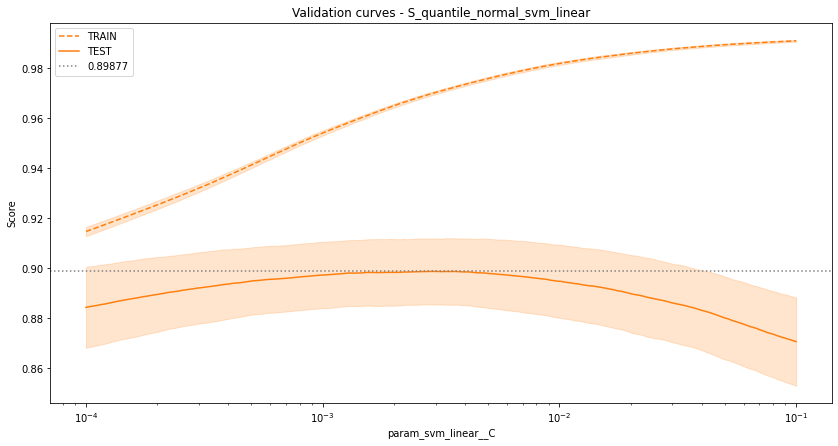

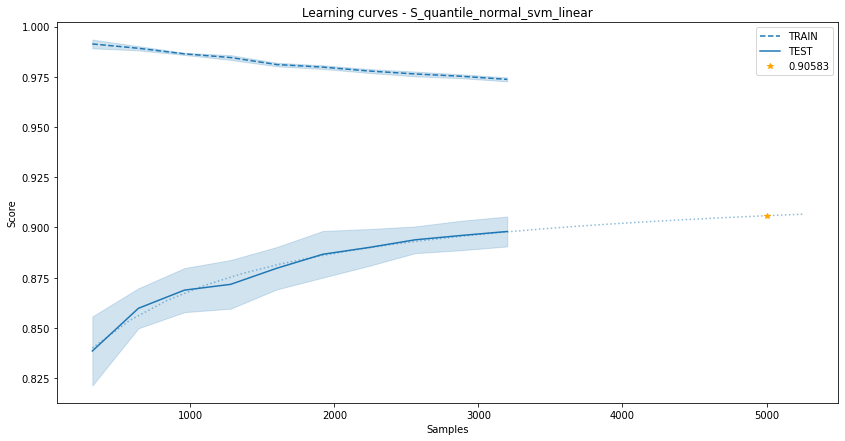

In [15]:
S_quantile_normal_svm_linear = GridSearchCV(
    Pipeline(
        [
            ("quantile", QuantileTransformer(output_distribution="normal")),
            ("svm_linear", LinearSVC(class_weight="balanced", random_state=42)),
        ],
        memory=caches,
    ),
    {"svm_linear__C": np.logspace(-4, -1, 200),},
    **GS
)

S_quantile_normal_svm_linear = fit(S_quantile_normal_svm_linear, S_X_train, y_train)

diagram(S_quantile_normal_svm_linear)
plot_validation_curves(S_quantile_normal_svm_linear, "param_svm_linear__C")
plot_learning_curves(
    S_quantile_normal_svm_linear, S_X_train, y_train, len(train_target)
)

In [16]:
S_calibrated_quantile_normal_svm_linear = CalibratedClassifierCV(
    S_quantile_normal_svm_linear.best_estimator_, cv=10
)
S_calibrated_quantile_normal_svm_linear = fit(
    S_calibrated_quantile_normal_svm_linear, S_X_train, y_train
)

diagram(S_calibrated_quantile_normal_svm_linear)

FOUND	1 S_calibrated_quantile_normal_svm_linear estimators
LOAD	estimators/S_calibrated_quantile_normal_svm_linear_2021-08-23T14-28-31.joblib



### Non-Linear SVM

TODO wrote aboute kernel trick

FOUND	1 S_binarizer_svm_rbf estimators
LOAD	estimators/S_binarizer_svm_rbf_2021-08-23T15-22-54.joblib



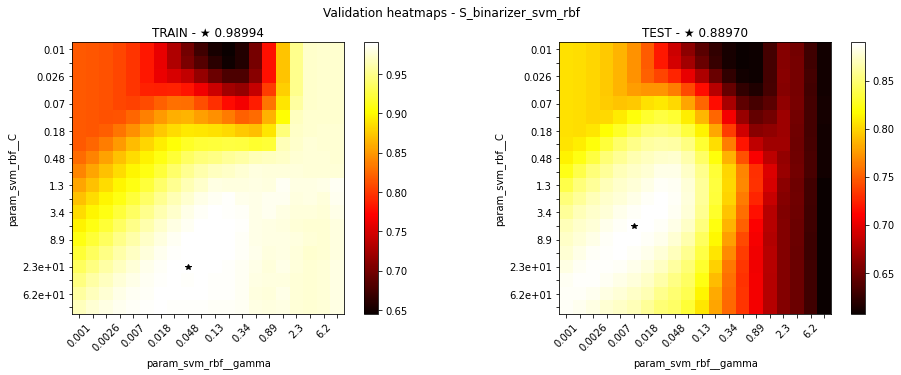

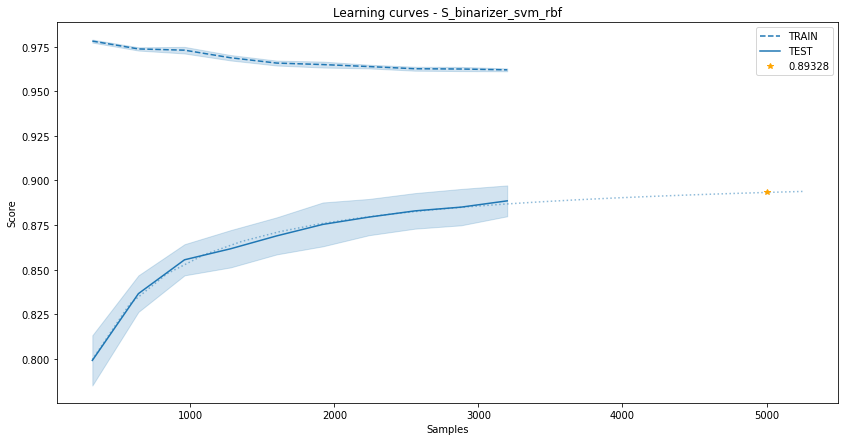

In [17]:
S_binarizer_svm_rbf = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            (
                "svm_rbf",
                SVC(
                    kernel="rbf",  # non-linear kernel
                    class_weight="balanced",
                    random_state=42,
                    probability=True,  # built probability estimation
                    cache_size=2000,  # kernel cache, faster traning
                ),
            ),
        ],
        memory=caches,
    ),
    {
        "svm_rbf__C": np.logspace(-2, 2, 20),  # prop to inverse of regularization
        "svm_rbf__gamma": np.logspace(-3, 1, 20),  # rbf param
    },
    **GS
)

S_binarizer_svm_rbf = fit(S_binarizer_svm_rbf, S_X_train, y_train)

diagram(S_binarizer_svm_rbf)
plot_validation_heatmaps(
    S_binarizer_svm_rbf, "param_svm_rbf__C", "param_svm_rbf__gamma"
)
plot_learning_curves(S_binarizer_svm_rbf, S_X_train, y_train, len(train_target))

There are two hyperparmas in the svm rbf model and the model must be optimize for both. A simple 1d-curve is no more sufficient to rappresent how scores variation during GridSearchCV. The GridSearchCV result are organized in a heatmap plot.

FOUND	1 S_quantile_normal_svm_rbf estimators
LOAD	estimators/S_quantile_normal_svm_rbf_2021-08-24T12-35-23.joblib



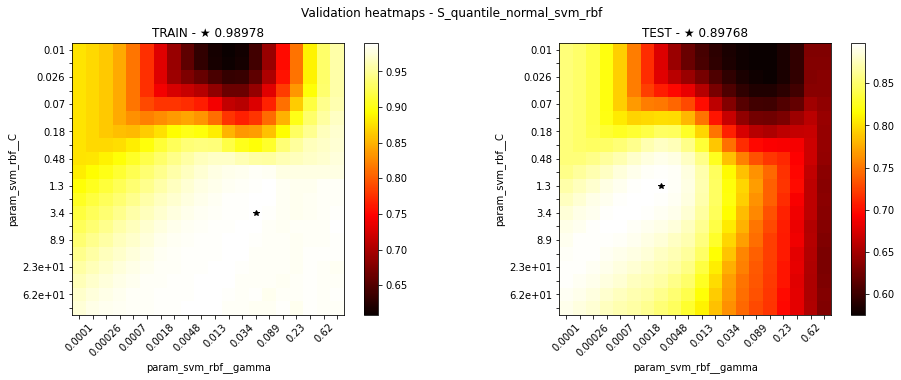

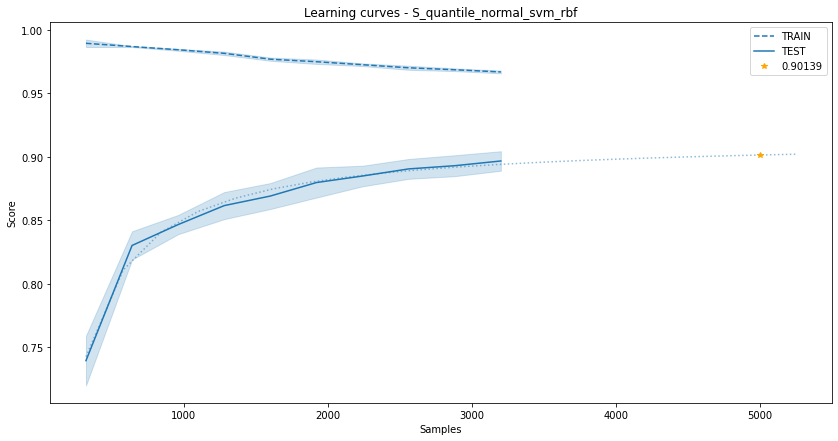

In [18]:
S_quantile_normal_svm_rbf = GridSearchCV(
    Pipeline(
        [
            ("quantile", QuantileTransformer(output_distribution="normal")),
            (
                "svm_rbf",
                SVC(
                    kernel="rbf",
                    class_weight="balanced",
                    random_state=42,
                    probability=True,
                    cache_size=2000,
                ),
            ),
        ],
        memory=caches,
    ),
    {"svm_rbf__C": np.logspace(-2, 2, 20), "svm_rbf__gamma": np.logspace(-4, 0, 20),},
    **GS
)

S_quantile_normal_svm_rbf = fit(S_quantile_normal_svm_rbf, S_X_train, y_train)

diagram(S_quantile_normal_svm_rbf)
plot_validation_heatmaps(
    S_quantile_normal_svm_rbf, "param_svm_rbf__C", "param_svm_rbf__gamma"
)
plot_learning_curves(S_quantile_normal_svm_rbf, S_X_train, y_train, len(train_target))

### Naive Bayes

Naive Bayes models leverage the power of Bayes theorem and built upon it. Two type of Naive Bayes model are explored: `ComplementNB` and `BernoulliNB`. BernoulliNB is designed for binary features so the preprocessing step is `Binarizer`. ComplementNB is a modification of MultinomialNB optimized for unbalanced dataset.

FOUND	1 S_binarizer_complement_nb estimators
LOAD	estimators/S_binarizer_complement_nb_2021-08-25T08-58-28.joblib



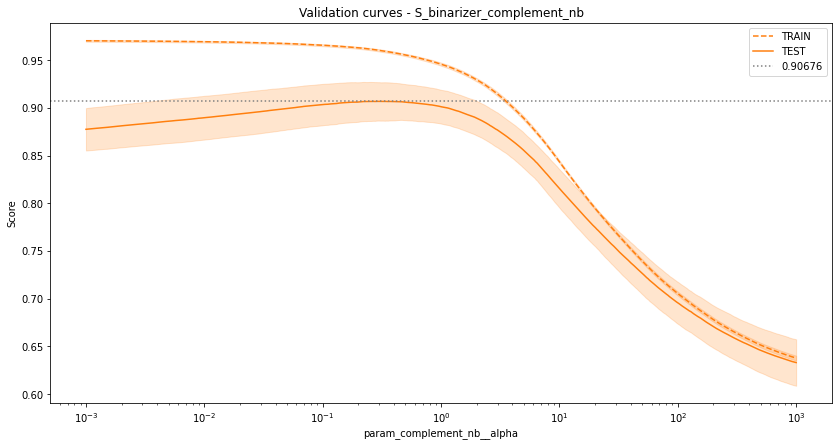

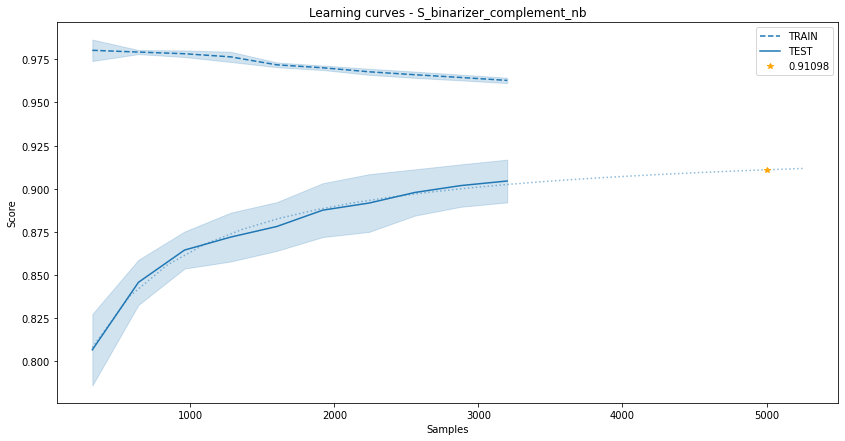

In [19]:
S_binarizer_complement_nb = GridSearchCV(
    Pipeline(
        [("binarizer", Binarizer()), ("complement_nb", ComplementNB()),], memory=caches,
    ),
    {"complement_nb__alpha": np.logspace(-3, 3, 500),},
    **GS
)

S_binarizer_complement_nb = fit(S_binarizer_complement_nb, S_X_train, y_train)

diagram(S_binarizer_complement_nb)
plot_validation_curves(S_binarizer_complement_nb, "param_complement_nb__alpha")
plot_learning_curves(S_binarizer_complement_nb, S_X_train, y_train, len(train_target))

FOUND	1 S_binarizer_bernoulli_nb estimators
LOAD	estimators/S_binarizer_bernoulli_nb_2021-08-25T08-59-00.joblib



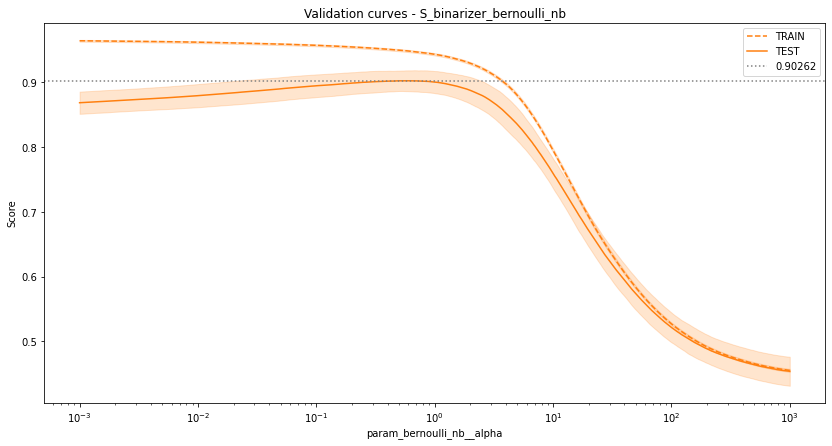

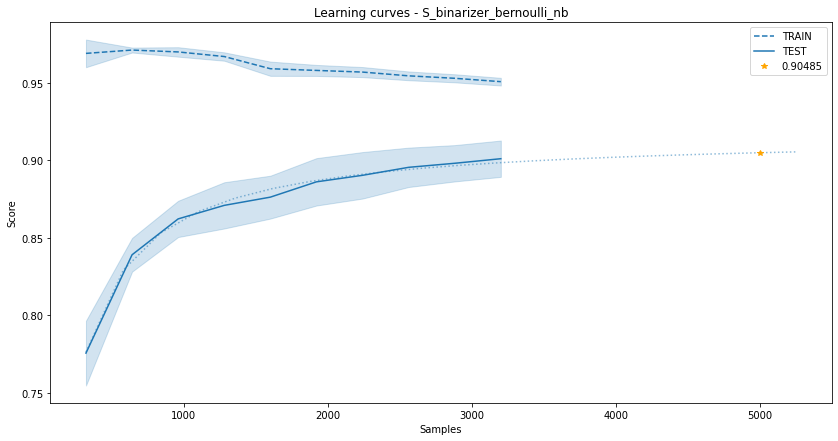

In [20]:
S_binarizer_bernoulli_nb = GridSearchCV(
    Pipeline(
        [("binarizer", Binarizer()), ("bernoulli_nb", BernoulliNB()),], memory=caches,
    ),
    {"bernoulli_nb__alpha": np.logspace(-3, 3, 500),},
    **GS
)

S_binarizer_bernoulli_nb = fit(S_binarizer_bernoulli_nb, S_X_train, y_train)

diagram(S_binarizer_bernoulli_nb)
plot_validation_curves(S_binarizer_bernoulli_nb, "param_bernoulli_nb__alpha")
plot_learning_curves(S_binarizer_bernoulli_nb, S_X_train, y_train, len(train_target))

### Multi Layer Perceptron

FOUND	1 S_binarizer_svd_mlp estimators
LOAD	estimators/S_binarizer_svd_mlp_2021-08-25T10-38-44.joblib



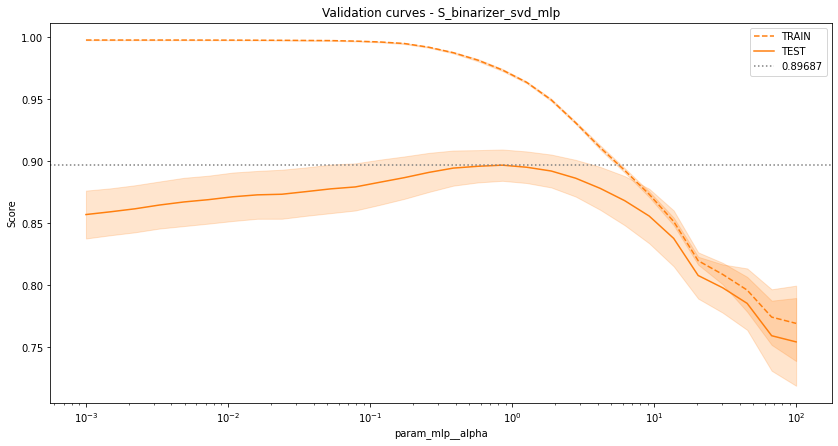

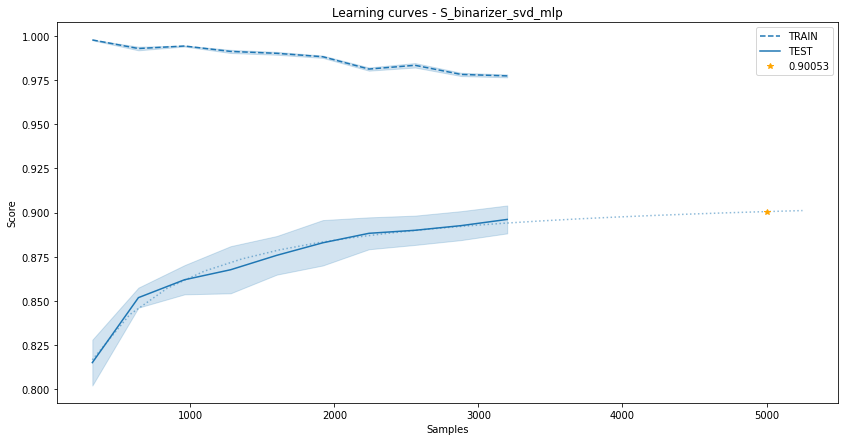

In [21]:
S_binarizer_svd_mlp = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            ("svd", TruncatedSVD(n_components=1500)),
            ("mlp", MLPClassifier(max_iter=500, random_state=42)),
        ],
        memory=caches,
    ),
    {"mlp__alpha": np.logspace(-3, 2, 30),},
    **GS
)

S_binarizer_svd_mlp = fit(S_binarizer_svd_mlp, S_X_train, y_train)

diagram(S_binarizer_svd_mlp)
plot_validation_curves(S_binarizer_svd_mlp, "param_mlp__alpha")
plot_learning_curves(S_binarizer_svd_mlp, S_X_train, y_train, len(train_target))

Multi Layer Perceptron seems to yield good predictions so it make sense (litteary) to go deeper. The previous `MLPClassifier` consists of only one hidden layer with 100 neurons. As suggested by sklearn docs, there are other libraries to experimenting with more complex Neural Nets model; one of them is *Keras*, a frendly API on top in tensorflow. For hyperparms optimization will be used `keras_tuner`.

In [22]:
def hypermodel(hp):

    inputs = tf.keras.Input(shape=(S_X_train.shape[1],))
    x = tf.keras.layers.Dense(hp.Choice("units_1", [32, 64, 128]), activation="relu")(
        inputs
    )
    x = tf.keras.layers.Dropout(hp.Float("dropout_1", 0, 0.5))(x)
    x = tf.keras.layers.Dense(hp.Choice("units_2", [16, 32, 64]), activation="relu")(x)
    x = tf.keras.layers.Dropout(hp.Float("dropout_2", 0, 0.5))(x)
    x = tf.keras.layers.Dense(hp.Choice("units_3", [8, 16, 32]), activation="relu")(x)
    x = tf.keras.layers.Dropout(hp.Float("dropout_3", 0, 0.5))(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name="roc_auc")],
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
    )

    return model


tuner = kt.Hyperband(
    hypermodel,
    kt.Objective("val_roc_auc", direction="max"),
    max_epochs=10,
    directory="estimators",
    project_name="S_binarizer_neural_net",
)

tuner.search(
    x=Binarizer().transform(S_X_train).toarray(),  # binarize and densify
    y=y_train[..., np.newaxis],  # [0, 1, ...] -> [[0], [1], ...]
    batch_size=8,
    epochs=10,
    validation_split=0.2,
)

S_binarizer_neural_net = tuner.get_best_models()[0]
S_binarizer_neural_net.summary()

INFO:tensorflow:Reloading Oracle from existing project estimators/S_binarizer_neural_net/oracle.json
INFO:tensorflow:Reloading Tuner from estimators/S_binarizer_neural_net/tuner0.json
INFO:tensorflow:Oracle triggered exit


2021-09-07 23:54:30.018362: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3329)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               426240    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0     

Test score is similar with the one from `MLPClassifier`. In the following only the sklearn model will be consider.

In [23]:
y_pred = S_binarizer_neural_net.predict(Binarizer().transform(S_X_test).toarray())
print(f"test score (AUC): {roc_auc_score(y_test, y_pred):0.5f}")

2021-09-07 23:54:30.649403: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


test score (AUC): 0.88881


## Performance

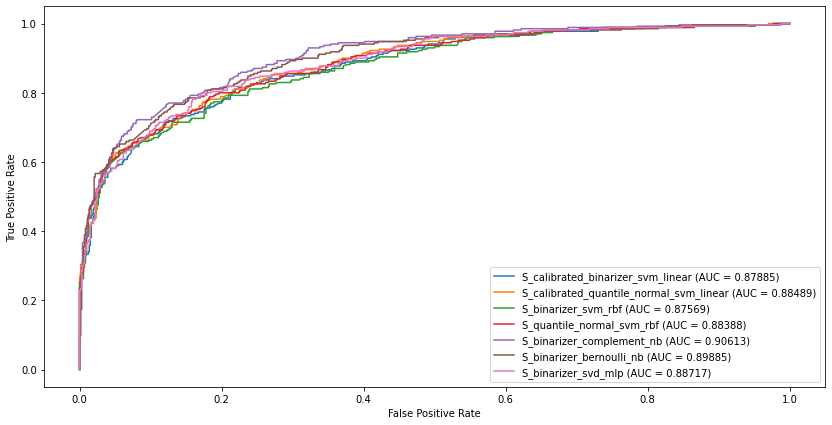

In [24]:
S_estimators = [
    S_calibrated_binarizer_svm_linear,
    S_calibrated_quantile_normal_svm_linear,
    S_binarizer_svm_rbf,
    S_quantile_normal_svm_rbf,
    S_binarizer_complement_nb,
    S_binarizer_bernoulli_nb,
    S_binarizer_svd_mlp,
]


fig, ax = plt.subplots(figsize=(14, 7))

for estimator in S_estimators:
    y_pred = estimator.predict_proba(S_X_test)[:, 1]
    plot_roc_curve(y_test, y_pred, ax, estimator.name)

plt.show()

In [25]:
# SVM

S_quantile_normal_svm_linear_final = GridSearchCV(
    Pipeline(
        [
            ("quantile", QuantileTransformer(output_distribution="normal")),
            ("svm_linear", LinearSVC(class_weight="balanced", random_state=42)),
        ],
        memory=caches,
    ),
    {"svm_linear__C": np.logspace(-4, -1, 200),},
    **GS
)

S_quantile_normal_svm_linear_final = fit(
    S_quantile_normal_svm_linear_final, S_X_TRAIN, Y
)
S_calibrated_quantile_normal_svm_linear_final = CalibratedClassifierCV(
    S_quantile_normal_svm_linear_final.best_estimator_, cv=10
)
S_calibrated_quantile_normal_svm_linear_final = fit(
    S_calibrated_quantile_normal_svm_linear_final, S_X_TRAIN, Y
)


# Naive Bayes

S_binarizer_complement_nb_final = GridSearchCV(
    Pipeline(
        [("binarizer", Binarizer()), ("complement_nb", ComplementNB()),], memory=caches,
    ),
    {"complement_nb__alpha": np.logspace(-3, 3, 500),},
    **GS
)
S_binarizer_complement_nb_final = fit(S_binarizer_complement_nb_final, S_X_TRAIN, Y)


# MLP

S_binarizer_svd_mlp_final = GridSearchCV(
    Pipeline(
        [
            ("binarizer", Binarizer()),
            ("svd", TruncatedSVD(n_components=1500)),
            ("mlp", MLPClassifier(max_iter=500, random_state=42)),
        ],
        memory=caches,
    ),
    {"mlp__alpha": np.logspace(-3, 2, 30),},
    **GS
)

S_binarizer_svd_mlp_final = fit(S_binarizer_svd_mlp_final, S_X_TRAIN, Y)

FOUND	1 S_quantile_normal_svm_linear_final estimators
LOAD	estimators/S_quantile_normal_svm_linear_final_2021-08-25T12-59-13.joblib

FOUND	1 S_calibrated_quantile_normal_svm_linear_final estimators
LOAD	estimators/S_calibrated_quantile_normal_svm_linear_final_2021-08-25T14-08-57.joblib

FOUND	1 S_binarizer_complement_nb_final estimators
LOAD	estimators/S_binarizer_complement_nb_final_2021-08-25T14-09-23.joblib

FOUND	1 S_binarizer_svd_mlp_final estimators
LOAD	estimators/S_binarizer_svd_mlp_final_2021-08-25T14-09-55.joblib



In [26]:
solution(S_calibrated_quantile_normal_svm_linear_final, S_X_TEST)
solution(S_binarizer_complement_nb_final, S_X_TEST)
solution(S_binarizer_svd_mlp_final, S_X_TEST)

SOL. EXISTS AT 	solutions/S_calibrated_quantile_normal_svm_linear_final_2021-08-25T14-08-57.csv
SOL. EXISTS AT 	solutions/S_binarizer_complement_nb_final_2021-08-25T14-09-23.csv
SOL. EXISTS AT 	solutions/S_binarizer_svd_mlp_final_2021-08-25T14-09-55.csv


In the table below are summarized the more successful model for each type

|type                    | model                        | test score | predicted kaggle score | kaggle score |
| ---------------------- | ---------------------------- | ---------- | ---------------------- | ------------ |
| Support Vector Machine | S_quantile_normal_svm_linear | 0.88489    | 0.90583                | 0.90684      |
| Naive Bayes            | S_binarizer_complement_nb    | 0.90613    | 0.91098                | 0.91384      |
| Multi Layer Perceptron | S_binarizer_svd_mlp          | 0.88717    | 0.90053                | 0.90346      |


## Ensambles

In [27]:
S_best_estimators = [
    ("svm", S_calibrated_binarizer_svm_linear),
    ("nb", S_binarizer_complement_nb.best_estimator_),
    ("mpl", S_binarizer_svd_mlp.best_estimator_),
]

FOUND	1 S_stacking estimators
LOAD	estimators/S_stacking_2021-08-26T14-56-40.joblib



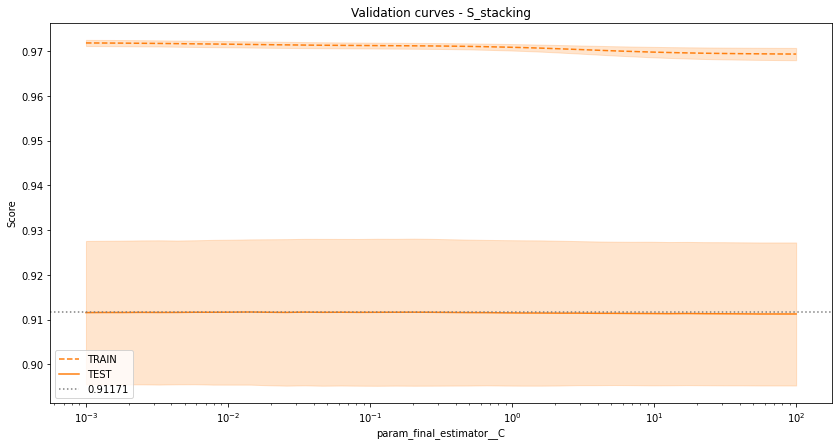

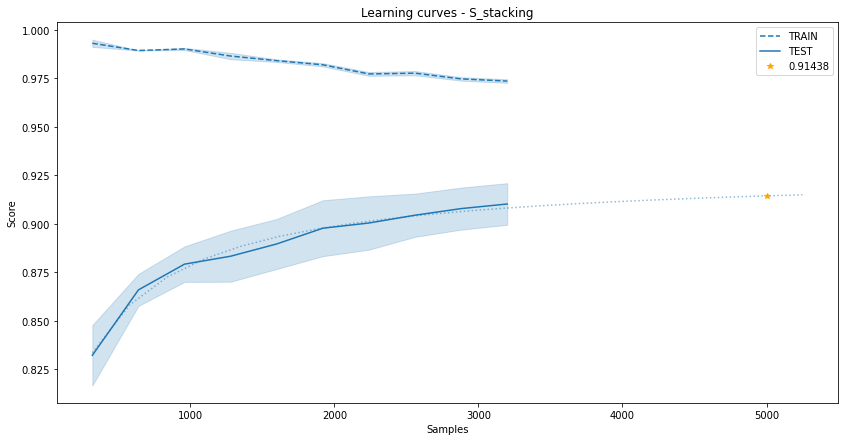

In [28]:
S_stacking = GridSearchCV(
    StackingClassifier(
        S_best_estimators,
        LogisticRegression(class_weight="balanced", random_state=42),
        cv=10,
        n_jobs=-1,
        stack_method="predict_proba",
    ),
    {"final_estimator__C": np.logspace(-3, 2, 40),},
    **GS
)


S_stacking = fit(S_stacking, S_X_train, y_train)

diagram(S_stacking)
plot_validation_curves(S_stacking, "param_final_estimator__C")
plot_learning_curves(S_stacking, S_X_train, y_train, len(train_target))

In [29]:
S_voting = VotingClassifier(S_best_estimators, voting="soft", n_jobs=-1)

S_voting = fit(S_voting, S_X_train, y_train)

diagram(S_voting)

FOUND	1 S_voting estimators
LOAD	estimators/S_voting_2021-08-26T22-15-57.joblib



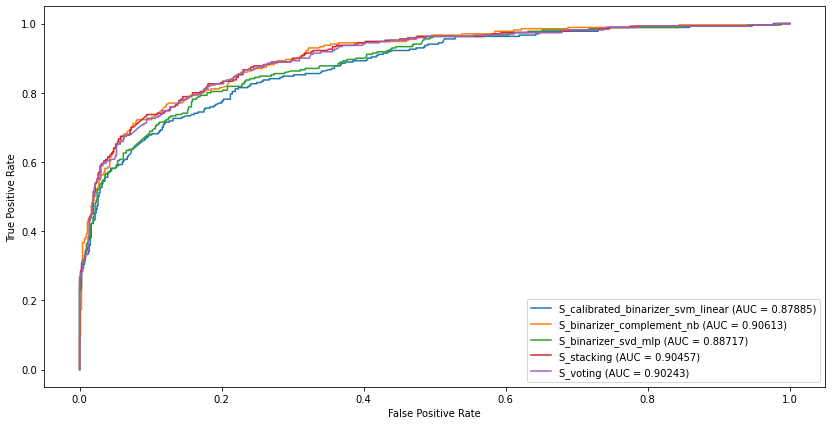

In [30]:
S_estimators = [
    S_calibrated_binarizer_svm_linear,
    S_binarizer_complement_nb,
    S_binarizer_svd_mlp,
    S_stacking,
    S_voting,
]


fig, ax = plt.subplots(figsize=(14, 7))

for estimator in S_estimators:
    y_pred = estimator.predict_proba(S_X_test)[:, 1]
    plot_roc_curve(y_test, y_pred, ax, estimator.name)

plt.show()

# Feature - Text

In [31]:
REGEX = [
    re.compile(r"[\w.-]+@[\w.-]+"),  # emails
    re.compile(r"(http|www)[^\s]+"),  # urls
    re.compile(r"[\d]{2,4}[ -/:]*[\d]{2,4}([ -/:]*[\d]{2,4})?"),  # dates
    re.compile("<.*?>"),  # html tags
    re.compile("<!--.*?-->"),  # html comments
    re.compile(r"&gt;"),  # html unescaped
]


def clean_with_regex(text):
    for regex in REGEX:
        text = regex.sub("", text)
    return re.sub(r"[\s]+", " ", text).strip()


def text(data, path, load=True):
    if not load or not path.is_file():
        texts = [
            clean_with_regex(group.body.str.cat(sep=" "))
            for _, group in tqdm(
                data.groupby("author"), desc=f"GENERATING {path.stem} "
            )
        ]
        with open(path, "w") as f:
            for author in texts:
                f.write(f"{author}\n")

    with open(path) as f:
        texts = f.read().splitlines()
    print(f"LOAD {path.stem} from {path}")

    return texts


T_TRAIN = text(train_data, working_path / "features" / "T_TRAIN.txt")
T_TEST = text(test_data, working_path / "features" / "T_TEST.txt")

# Split T_TRAIN in T_train and T_test. test will be used to evaluate the performance.
T_train, T_test, y_train, y_test = train_test_split(
    T_TRAIN, Y, test_size=0.20, random_state=42, stratify=Y
)

LOAD T_TRAIN from features/T_TRAIN.txt
LOAD T_TEST from features/T_TEST.txt


In [32]:
T_complement_nb = GridSearchCV(
    Pipeline(
        [
            ("vectorizer", CountVectorizer(binary=True)),
            ("tfidf", TfidfTransformer()),
            ("nb", ComplementNB()),
        ],
        memory=caches,
    ),
    {
        "vectorizer__max_features": (None, 20000, 35000, 50000, 75000, 90000),
        "vectorizer__max_df": (0.85, 0.9, 0.95, 1.0),
        "tfidf__use_idf": (True, False),
        "tfidf__sublinear_tf": (True, False),
        "nb__alpha": np.logspace(-3, 1, 50),
    },
    n_jobs=-1,
    scoring="roc_auc",
    verbose=1,
)

T_complement_nb = fit(T_complement_nb, T_train, y_train)

diagram(T_complement_nb)
print(f"\nBEST ESTIMATOR - Validation score (AUC): {T_complement_nb.best_score_}")
diagram(T_complement_nb.best_estimator_)

FOUND	1 T_complement_nb estimators
LOAD	estimators/T_complement_nb_2021-09-04T08-13-04.joblib




BEST ESTIMATOR - Validation score (AUC): 0.8785586644765921


## More sophisticated preprocessing

In [33]:
nlp = en_core_web_lg.load(exclude=["parser", "ner"])


def text2token(data, path, load=True):
    if not load or not path.is_file():
        tokens = [
            ",".join(
                [
                    token.lemma_
                    for doc in nlp.pipe(group.body)
                    for token in doc
                    if not (
                        token.is_punct | token.is_space | token.is_stop | token.is_oov
                    )
                ]
            )
            for _, group in tqdm(
                data.groupby("author"), desc=f"GENERATING {path.stem} "
            )
        ]
        with open(path, "w") as f:
            for author in tokens:
                f.write(f"{author}\n")

    with open(path) as f:
        tokens = f.read().splitlines()
    print(f"LOAD {path.stem} from {path}")

    return tokens


K_TRAIN = text2token(train_data, working_path / "features" / f"K_TRAIN.txt")
K_TEST = text2token(test_data, working_path / "features" / f"K_TEST.txt")

K_train, K_test, y_train, y_test = train_test_split(
    K_TRAIN, Y, test_size=0.20, random_state=42, stratify=Y
)

LOAD K_TRAIN from features/K_TRAIN.txt
LOAD K_TEST from features/K_TEST.txt


In [34]:
K_complement_nb = GridSearchCV(
    Pipeline(
        [
            (
                "vectorizer",
                CountVectorizer(
                    lowercase=False,
                    binary=True,
                    token_pattern=r"([^,]+)",
                    # same as
                    # tokenizer=lambda x: x.split(","),
                    # but no pickle errors raised.
                ),
            ),
            ("tfidf", TfidfTransformer()),
            ("nb", ComplementNB()),
        ],
        memory=caches,
    ),
    {
        "vectorizer__max_features": (None, 10000, 20000, 30000),
        "vectorizer__max_df": (0.70, 0.75, 0.80, 0.85, 0.9, 0.95, 1.0),
        "tfidf__use_idf": (True, False),
        "tfidf__sublinear_tf": (True, False),
        "nb__alpha": np.logspace(-3, 1, 50),
    },
    n_jobs=-1,
    scoring="roc_auc",
    verbose=1,
)

K_complement_nb = fit(K_complement_nb, K_train, y_train)

diagram(K_complement_nb)
print(f"\nBEST ESTIMATOR - Validation score (AUC): {K_complement_nb.best_score_}")
diagram(K_complement_nb.best_estimator_)

FOUND	1 K_complement_nb estimators
LOAD	estimators/K_complement_nb_2021-09-05T11-04-50.joblib




BEST ESTIMATOR - Validation score (AUC): 0.8756032321070549


In [35]:
"""
Statring from gensim 4.0.0 sklearn_api wrappers are no more maintained
As suggested in the wiki
(https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4)
older chunk of code from Gensim 3.8.3 can be reused and extend
to work with sklearn.

Copyright (C) 2011 Radim Rehurek <radimrehurek@seznam.cz>
Licensed under the GNU LGPL v2.1 - http://www.gnu.org/licenses/lgpl.html
"""


class TqdmCallback(CallbackAny2Vec):
    """Callback for display doc2vec training progress bar."""

    def __init__(self, epochs, desc):
        self.pbar = tqdm(total=epochs, desc=desc)
        self.epoch = 0

    def on_epoch_end(self, model):
        self.pbar.update(1)
        self.epoch += 1

    def on_train_end(self, model):
        self.pbar.close()


class D2VTransformer(TransformerMixin, BaseEstimator):
    """Base Doc2Vec module

    This model based on `Quoc Le, Tomas Mikolov:
    "Distributed Representations of Sentences and Documents"
    <https://cs.stanford.edu/~quocle/paragraph_vector.pdf>`_.
    """

    def __init__(
        self, vector_size=100, dm=1, window=5, min_count=0, epochs=20,
    ):

        self.model = None
        self.name = f"vec{vector_size}_dm{dm}_min{min_count}"
        self.callbacks = [TqdmCallback(epochs, f"TRAINING EMBEDDING {self.name} ")]

        self.vector_size = vector_size
        self.dm = dm
        self.window = window
        self.min_count = min_count
        self.epochs = epochs

    def fit(self, X, y=None):

        np.random.seed(42)
        np.random.shuffle(X)

        docs = [TaggedDocument(doc.split(","), [i]) for i, doc in enumerate(X)]

        model = Doc2Vec(
            vector_size=self.vector_size,
            dm=self.dm,
            window=self.window,
            min_count=self.min_count,
            epochs=self.epochs,
            sample=0,
            workers=CPU,
            negative=5,
            hs=0,
            callbacks=self.callbacks,
        )

        model.build_vocab(docs)
        model.train(
            docs,
            total_examples=model.corpus_count,
            epochs=model.epochs,
            callbacks=self.callbacks,
        )
        self.model = model

        return self

    def transform(self, X):

        if self.model is None:
            raise NotFittedError(
                "This model has not been fitted yet. Call 'fit' "
                "with appropriate arguments before using this method."
            )

        docs = [doc.split(",") for doc in X]

        return np.array(
            [
                self.model.infer_vector(doc)
                for doc in tqdm(docs, desc=f"GENERATING EMBEDDING {self.name} ")
            ],
            dtype="float32",
        )

In [36]:
# E for Embeddings
E_trains = {}
E_tests = {}

grid = {
    "vector_size": (100, 200, 300),
    "dm": (0, 1),
    "min_count": (0, 1, 2),
}

for params in ParameterGrid(grid):
    name = f"vec{params['vector_size']}_dm{params['dm']}_min{params['min_count']}"
    E_TRAIN_path = working_path / "features" / f"E_TRAIN_{name}.npy"

    if not E_TRAIN_path.is_file():
        d2v = D2VTransformer(**params).fit(K_TRAIN + K_TEST)
        np.save(E_TRAIN_path, d2v.transform(K_TRAIN))

    print(f"LOAD {name} from {E_TRAIN_path}")
    E_trains[name], E_tests[name], y_train, y_test = train_test_split(
        np.load(E_TRAIN_path), Y, test_size=0.20, random_state=42, stratify=Y
    )

LOAD vec100_dm0_min0 from features/E_TRAIN_vec100_dm0_min0.npy
LOAD vec200_dm0_min0 from features/E_TRAIN_vec200_dm0_min0.npy
LOAD vec300_dm0_min0 from features/E_TRAIN_vec300_dm0_min0.npy
LOAD vec100_dm0_min1 from features/E_TRAIN_vec100_dm0_min1.npy
LOAD vec200_dm0_min1 from features/E_TRAIN_vec200_dm0_min1.npy
LOAD vec300_dm0_min1 from features/E_TRAIN_vec300_dm0_min1.npy
LOAD vec100_dm0_min2 from features/E_TRAIN_vec100_dm0_min2.npy
LOAD vec200_dm0_min2 from features/E_TRAIN_vec200_dm0_min2.npy
LOAD vec300_dm0_min2 from features/E_TRAIN_vec300_dm0_min2.npy
LOAD vec100_dm1_min0 from features/E_TRAIN_vec100_dm1_min0.npy
LOAD vec200_dm1_min0 from features/E_TRAIN_vec200_dm1_min0.npy
LOAD vec300_dm1_min0 from features/E_TRAIN_vec300_dm1_min0.npy
LOAD vec100_dm1_min1 from features/E_TRAIN_vec100_dm1_min1.npy
LOAD vec200_dm1_min1 from features/E_TRAIN_vec200_dm1_min1.npy
LOAD vec300_dm1_min1 from features/E_TRAIN_vec300_dm1_min1.npy
LOAD vec100_dm1_min2 from features/E_TRAIN_vec100_dm1_m

In [37]:
# for simple CV search it's faster
# than GridSearch(LogisticRegression(...), ...)
lr = LogisticRegressionCV(
    class_weight="balanced",
    random_state=42,
    Cs=np.logspace(-3, -1, 10),
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
)

results = pd.DataFrame(columns=["Embedding", "Score", "C"])
for name, x in E_trains.items():
    lr.fit(x, y_train)
    results.loc[len(results.index)] = (name, lr.scores_[1].mean(axis=0).max(), lr.C_[0])
results.sort_values("Score", ascending=False)

,Embedding,Score,C
0,vec100_dm0_min0,0.902811,0.035938
5,vec300_dm0_min1,0.902675,0.012915
3,vec100_dm0_min1,0.901959,0.035938
7,vec200_dm0_min2,0.901715,0.021544
1,vec200_dm0_min0,0.901299,0.021544
4,vec200_dm0_min1,0.901292,0.021544
6,vec100_dm0_min2,0.901055,0.035938
8,vec300_dm0_min2,0.900527,0.012915
2,vec300_dm0_min0,0.900029,0.012915
15,vec100_dm1_min2,0.875444,0.002783


In [38]:
# Choose one embedding
E_TEST_path = working_path / "features" / f"E_TEST.npy"
E_TRAIN_path = working_path / "features" / f"E_TRAIN.npy"

if not E_TEST_path.is_file() or not E_TRAIN_path.is_file():
    d2v = D2VTransformer(vector_size=100, dm=0, min_count=0).fit(K_TRAIN + K_TEST)
    np.save(E_TEST_path, d2v.transform(K_TEST))
    np.save(E_TRAIN_path, d2v.transform(K_TRAIN))

E_TEST = np.load(E_TEST_path)
print(f"LOAD E_TEST from {E_TEST_path}")
E_TRAIN = np.load(E_TRAIN_path)
print(f"LOAD E_TRAIN from {E_TRAIN_path}")

E_train, E_test, y_train, y_test = train_test_split(
    E_TRAIN, Y, test_size=0.20, random_state=42, stratify=Y
)

LOAD E_TEST from features/E_TEST.npy
LOAD E_TRAIN from features/E_TRAIN.npy


FOUND	1 E_lr estimators
LOAD	estimators/E_lr_2021-09-07T15-53-24.joblib



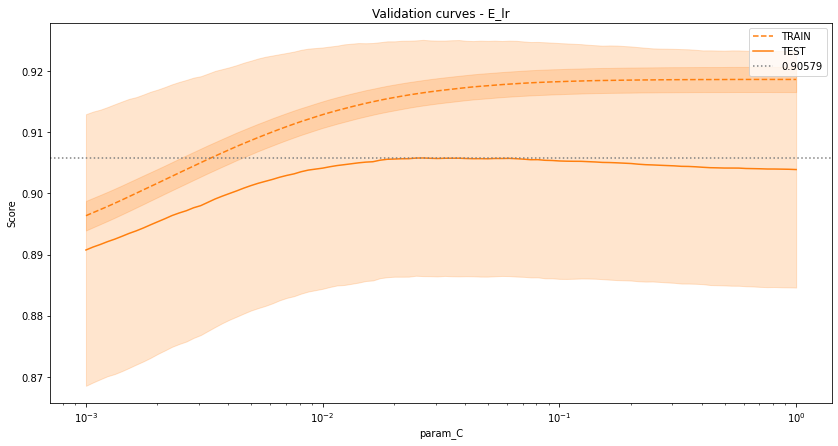

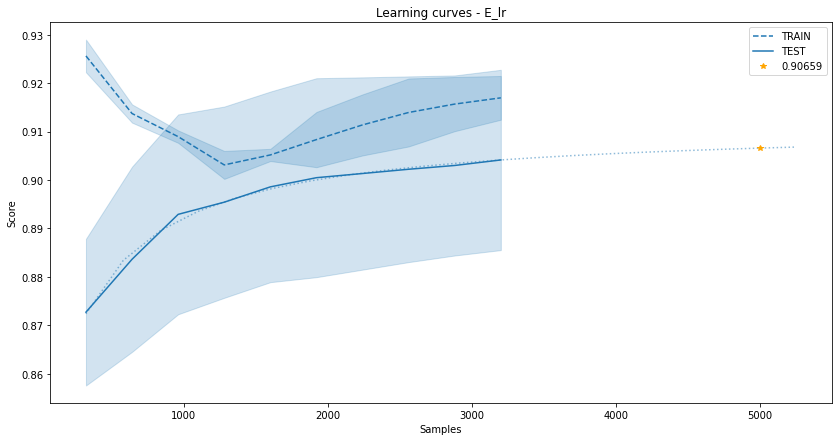

In [39]:
E_lr = GridSearchCV(
    LogisticRegression(class_weight="balanced", random_state=42, n_jobs=-1,),
    {"C": np.logspace(-3, 0, 100),},
    **GS
)

E_lr = fit(E_lr, E_train, y_train)

diagram(E_lr)
plot_validation_curves(E_lr, "param_C")
plot_learning_curves(E_lr, E_train, y_train, len(Y))

In [40]:
def hypermodel(hp):

    inputs = tf.keras.Input(shape=(100,))
    x = tf.keras.layers.Dense(hp.Choice("units_1", [32, 64, 128]), activation="relu")(
        inputs
    )
    x = tf.keras.layers.Dropout(hp.Float("dropout_1", 0, 0.5))(x)
    x = tf.keras.layers.Dense(hp.Choice("units_2", [16, 32, 64]), activation="relu")(x)
    x = tf.keras.layers.Dropout(hp.Float("dropout_2", 0, 0.5))(x)
    x = tf.keras.layers.Dense(hp.Choice("units_3", [8, 16, 32]), activation="relu")(x)
    x = tf.keras.layers.Dropout(hp.Float("dropout_3", 0, 0.5))(x)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name="roc_auc")],
        optimizer=tf.keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
    )

    return model


tuner = kt.Hyperband(
    hypermodel,
    kt.Objective("val_roc_auc", direction="max"),
    max_epochs=15,
    hyperband_iterations=7,
    seed=42,
    directory="estimators",
    project_name="E_neural_net",
)

tuner.search(
    x=E_train,
    y=y_train[..., np.newaxis],
    batch_size=8,
    epochs=10,
    validation_split=0.2,
)

E_neural_net = tuner.get_best_models()[0]
E_neural_net.summary()

INFO:tensorflow:Reloading Oracle from existing project estimators/E_neural_net/oracle.json
INFO:tensorflow:Reloading Tuner from estimators/E_neural_net/tuner0.json
INFO:tensorflow:Oracle triggered exit
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               12928     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________

## Performance

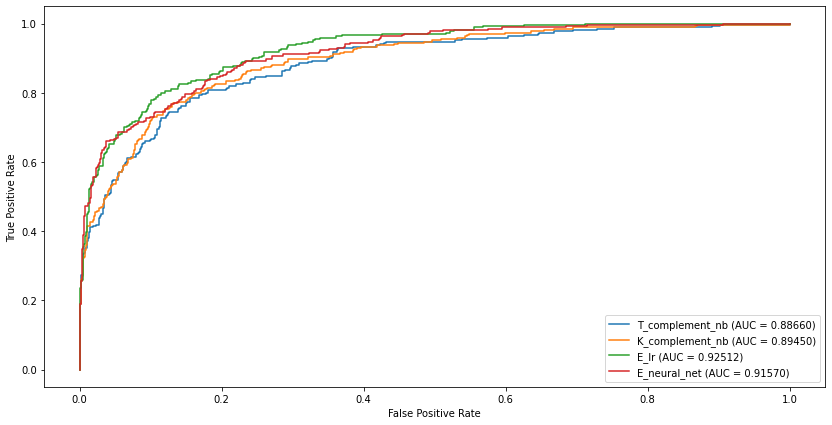

In [41]:
fig, ax = plt.subplots(figsize=(14, 7))

y_pred = T_complement_nb.predict_proba(T_test)[:, 1]
plot_roc_curve(y_test, y_pred, ax, "T_complement_nb")
y_pred = K_complement_nb.predict_proba(K_test)[:, 1]
plot_roc_curve(y_test, y_pred, ax, "K_complement_nb")
y_pred = E_lr.predict_proba(E_test)[:, 1]
plot_roc_curve(y_test, y_pred, ax, "E_lr")
y_pred = E_neural_net.predict(E_test)
plot_roc_curve(y_test, y_pred, ax, "E_neural_net")

plt.show()

All the classifer in the above plot are trained only on comments text. *T_complement_nb* is the classifier simplest classifer trained on the raw texts; it use sklearn `CountVectorizer` to transform text into a BOW vector. `CountVectorizer` does not implement sofisticated tokenizer and lemmatizer algorithm (just use regex to find all words and then lowercase them). `K_complement_nb` have the same structure of `K_complement_nb` but is trained on list of words extract from raw text using *Spacy*. *Spacy* implements a more sofisticated tokenizer (e.g. `"I live in New York"`-> `[I", "live", "in", "New York"]`) followed by a Lemmatizer. A finer text preprocessing produce a slightly better result.


Insted of counting words occurences, a completly differnt approach is word embedding (more precisly docs/sentences embedding). The results from *Spacy* preprocessing were fed into *gensim* `Doc2Vec`model (wrapped in custom sklearn `D2VTransformer`) to obtain a matrix of float number (each row correspond to a differnet user). Those vector are used as training data for `LogisticRegression` and `NeuralNetwork` models.

In [42]:
# # TEXT
# T_complement_nb_final = GridSearchCV(
#     Pipeline(
#         [
#             ("vectorizer", CountVectorizer(binary=True)),
#             ("tfidf", TfidfTransformer(use_idf=False, sublinear_tf=True)),
#             ("nb", ComplementNB()),
#         ],
#         memory=caches,
#     ),
#     {
#         "vectorizer__max_features": (None, 20000, 35000, 40000, 50000),
#         "vectorizer__max_df": (0.85, 0.9, 0.95, 1.0),
#         "nb__alpha": np.logspace(-3, 1, 100),
#     },
#     n_jobs=-1,
#     scoring="roc_auc",
#     verbose=1,
# )

# T_complement_nb_final = fit(T_complement_nb_final, T_TRAIN, Y)

# # TOKEN
# K_complement_nb_final = GridSearchCV(
#     Pipeline(
#         [
#             (
#                 "vectorizer",
#                 CountVectorizer(
#                     lowercase=False, binary=True, token_pattern=r"([^,]+)",
#                 ),
#             ),
#             ("tfidf", TfidfTransformer(use_idf=False, sublinear_tf=True)),
#             ("nb", ComplementNB()),
#         ],
#         memory=caches,
#     ),
#     {
#         "vectorizer__max_features": (None, 20000, 30000, 40000),
#         "vectorizer__max_df": (0.65, 0.70, 0.75, 0.80, 0.85, 0.9, 1.0),
#         "nb__alpha": np.logspace(-3, 1, 100),
#     },
#     n_jobs=-1,
#     scoring="roc_auc",
#     verbose=1,
# )

# K_complement_nb_final = fit(K_complement_nb_final, K_TRAIN, Y)

# EMBEDDING LR
E_lr_final = GridSearchCV(
    LogisticRegression(class_weight="balanced", random_state=42, n_jobs=-1,),
    {"C": np.logspace(-3, 0, 500),},
    **GS
)

E_lr_final = fit(E_lr_final, E_TRAIN, Y)

# # EMBEDDING NN
# tuner = kt.Hyperband(
#     hypermodel,
#     kt.Objective("val_roc_auc", direction="max"),
#     max_epochs=15,
#     hyperband_iterations=11,
#     seed=42,
#     directory="estimators",
#     project_name="E_neural_net_final",
# )

# tuner.search(
#     x=E_TRAIN, y=Y[..., np.newaxis], batch_size=8, epochs=10, validation_split=0.2,
# )

# E_neural_net_final = tuner.get_best_models()[0]

FOUND	1 E_lr_final estimators
LOAD	estimators/E_lr_final_2021-09-07T17-35-41.joblib



In [43]:
# solution(T_complement_nb_final, T_TEST)
# solution(K_complement_nb_final, K_TEST)
# solution(E_lr_final, E_TEST)
# solution(E_neural_net_final, E_TEST)

----
# Feature - Time

Another feature associated to each comment is *time* (when the comment was posted rappresent as unix epoch). If one gender, on average, starts to use Reddit earlier than the other, this feature can be meaninful for classification. Unfortunatly comments in the database belong to one month (2014-01 to 2014-02) so this beaviour cannot be observed. The following density-histogram shows that males and females comment follow the same distribution so no useful information can be extracted from this feature.

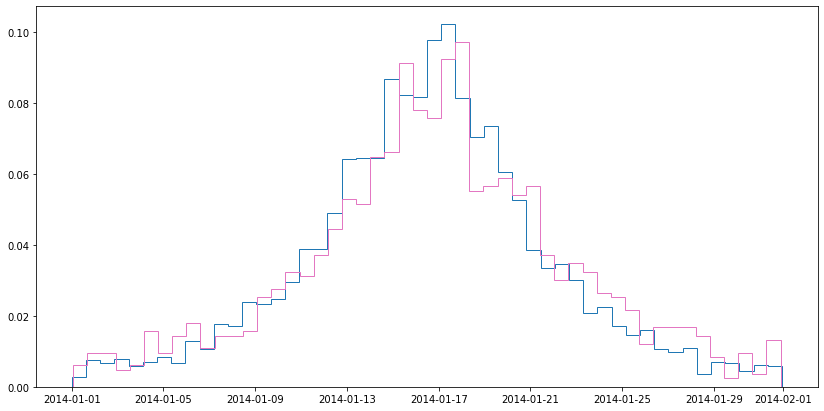

In [44]:
males, females = [], []
for author, group in train_data.groupby("author"):
    if train_target[author]:
        females.append(group.created_utc.mean())
    else:
        males.append(group.created_utc.mean())

plt.figure(figsize=(14, 7))
plt.hist(
    pd.to_datetime(males, unit="s"),
    density=True,
    bins=50,
    histtype="step",
    color="tab:blue",
)
plt.hist(
    pd.to_datetime(females, unit="s"),
    density=True,
    bins=50,
    histtype="step",
    color="tab:pink",
)
plt.show()

---
# Features - Subreddits and Text

To develop a model that (teoretically) can perform even better, all the relevant information contained in the training data should be used. This can be achived in models that combine subreddits-feature with text-feature. In the following I try to combine the previous models (that were successful) in a single one.

- **Soft voting classifier**: a simple average between the predictions of different classifier
- **Logistic regression**: stack the prediction from differnt classifer and then pass to a logisti regression estimator.

In [61]:
S_y_pred_train = S_binarizer_complement_nb.predict_proba(S_X_train)[:, 1]
E_y_pred_train = E_lr.predict_proba(E_train)[:, 1]

S_y_pred_test = S_binarizer_complement_nb.predict_proba(S_X_test)[:, 1]
E_y_pred_test = E_lr.predict_proba(E_test)[:, 1]

SE_y_pred_train = np.stack([S_y_pred_train, E_y_pred_train], axis=1)
SE_y_pred_test = np.stack([S_y_pred_test, E_y_pred_test], axis=1)

In [67]:
# simple soft voting classifier
scores = [
    roc_auc_score(y_test, S_y_pred_test),
    roc_auc_score(y_test, E_y_pred_test),  
]
SE_y_pred_soft_voting = np.average(SE_y_pred_test, axis=1, weights=scores)

In [48]:
# logistic regression
SE_lr = LogisticRegressionCV(
    class_weight="balanced",
    random_state=42,
    Cs=np.logspace(-6, -3, 200),
    cv=10,
    scoring="roc_auc",
    n_jobs=-1,
)

SE_lr.fit(SE_y_pred_train, y_train)
SE_y_pred_lr = SE_lr.predict_proba(SE_y_pred_test)[:, 1]

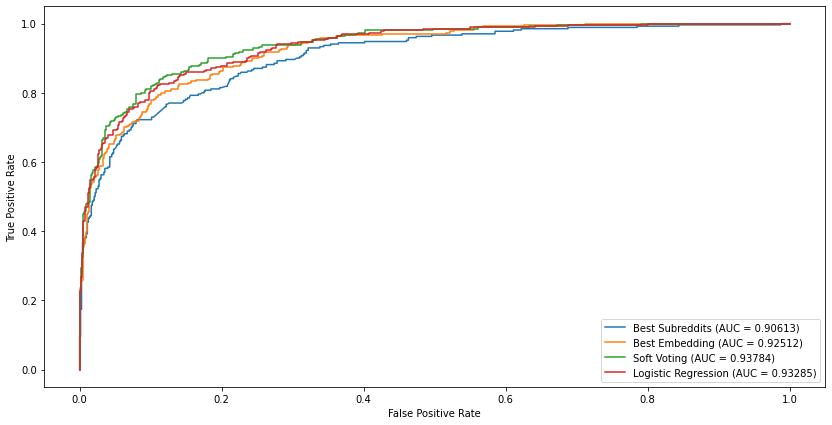

In [69]:
fig, ax = plt.subplots(figsize=(14, 7))

plot_roc_curve(y_test, S_y_pred_test, ax, "Best Subreddits")
plot_roc_curve(y_test, E_y_pred_test, ax, "Best Embedding")
plot_roc_curve(y_test, SE_y_pred_soft_voting, ax, "Soft Voting")
plot_roc_curve(y_test, SE_y_pred_lr, ax, "Logistic Regression")

Test score of the combine classifier definitly out perform classifer trained on only one feature. *Soft Voting* seems to perform slightly better than *Logistic Regression*. Now "train" the classifers on the entire training datasets for the final Kaggle score.

In [70]:
S_y_pred_TRAIN = S_binarizer_complement_nb_final.predict_proba(S_X_TRAIN)[:, 1]
E_y_pred_TRAIN = E_lr_final.predict_proba(E_TRAIN)[:, 1]

S_y_pred_TEST = S_binarizer_complement_nb_final.predict_proba(S_X_TEST)[:, 1]
E_y_pred_TEST = E_lr_final.predict_proba(E_TEST)[:, 1]

SE_y_pred_TRAIN = np.stack([S_y_pred_TRAIN, E_y_pred_TRAIN], axis=1)
SE_y_pred_TEST = np.stack([S_y_pred_TEST, E_y_pred_TEST], axis=1)


# simple soft voting classifier
SE_y_pred_soft_voting_final = np.average(SE_y_pred_TEST, axis=1, weights=scores)
pd.DataFrame({"author": TEST_AUTHORS, "gender": SE_y_pred_soft_voting_final}).to_csv(
    working_path / "solutions" / f"SE_soft_voting.csv",
    index=False,
)

# logistic regression
SE_lr_final = LogisticRegressionCV(
    class_weight="balanced",
    random_state=42,
    Cs=np.logspace(-7, -3, 200),
    cv=10,
    scoring="roc_auc",
    n_jobs=-1,
)
SE_lr_final.fit(SE_y_pred_TRAIN, Y)
SE_y_pred_lr_final = SE_lr_final.predict_proba(SE_y_pred_TEST)[:, 1]
pd.DataFrame({"author": TEST_AUTHORS, "gender": SE_y_pred_lr_final}).to_csv(
    working_path / "solutions" / f"SE_lr.csv",
    index=False,
)

Here are the results:

| model                                                            | test score | kaggle score |
| ---------------------------------------------------------------- | ---------- | ------------ |
| Soft classifier (Naive Bayes + Embedding Logisti Regression)     | 0.93784    | 0.93874      |
| Logistic Regression (Naive Bayes + Embedding Logisti Regression) | 0.93285    | 0.93653      |